In [1]:
from types import SimpleNamespace
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F

import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras
from keras import layers, models
from dataset import get_fmnist
from network import get_encoder, get_decoder, AE
from training import trainer
from testing import reconstruction, display

In [2]:
args = SimpleNamespace(dataset="fmnist")
args.device ="cuda" if torch.cuda.is_available() else "cpu"
args.img = 32       # image size
args.ch = 1         # num of channel
args.batch = 100    # batch size
args.dim = 2        # embedding dimension
args.epoch = 10
args.lr = 1e-3
print(args)

namespace(dataset='fmnist', device='cuda', img=32, ch=1, batch=100, dim=2, epoch=10, lr=0.001)


In [3]:
path = Path.home().joinpath("Documents","Data")
path.mkdir(exist_ok=True)
loader = get_fmnist(path, 100)
len(loader[0]),len(loader[1])

(600, 100)

In [4]:
x, y = next(iter(loader[0]))
x.shape, y.shape

(torch.Size([100, 32, 32, 1]), torch.Size([100]))

In [5]:
# Encoder
encoder, args.shape_bf = get_encoder(args.img, args.ch, args.dim)
print(args.shape_bf)
encoder.summary()

(4, 4, 128)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Decoder
decoder = get_decoder(args.dim, args.ch, args.shape_bf)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model = AE(args.img, args.ch, args.dim).to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
loss_fn = nn.BCELoss()

In [8]:
model, history = trainer(model, loader, args.epoch, 
                         optimizer, loss_fn, args.device)
model.training

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\yalin\anaconda3\envs\keras3\Lib\site-packages\keras\src\backend\common\backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(
100%|██████████| 10/10 [02:32<00:00, 15.27s/it]


False

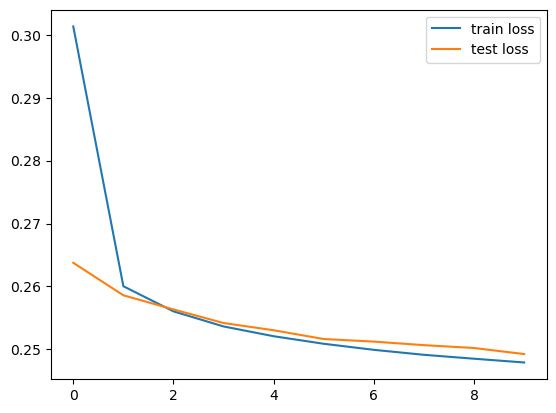

In [9]:
plt.plot(history["train"], label="train loss")
plt.plot(history["test"], label="test loss")
plt.legend()
plt.show()

In [10]:
# load the saved model
checkpoint = torch.load("best_model.pth", weights_only=True)
model.load_state_dict(checkpoint["model_dict"])
model.training

False

In [11]:
X, X_hat, Y = reconstruction(model, loader[1], 50, args.device)
X.shape, X_hat.shape, Y.shape

(torch.Size([5000, 32, 32, 1]),
 torch.Size([5000, 32, 32, 1]),
 torch.Size([5000]))

Example real clothing items


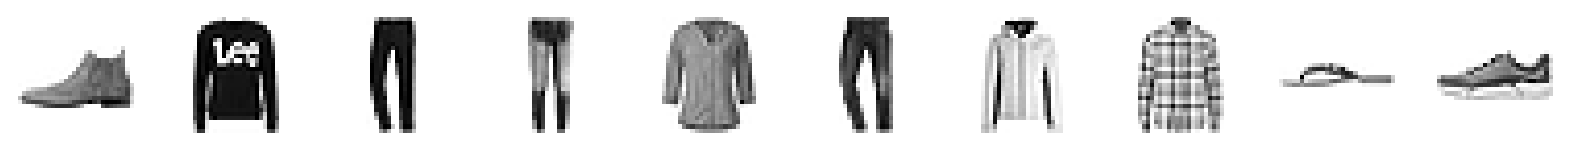

Correpsonding reconstructions


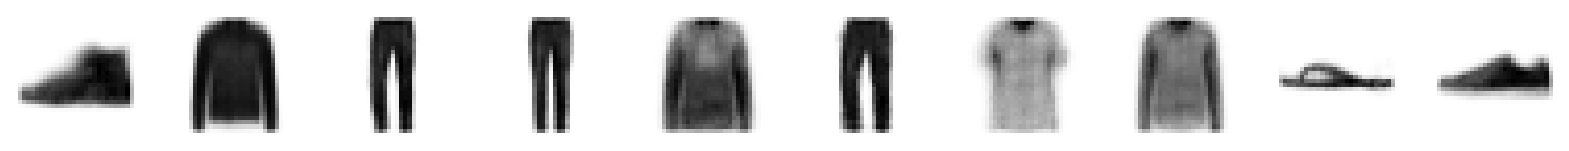

In [12]:
print("Example real clothing items")
display(X)
print("Correpsonding reconstructions")
display(X_hat)

In [13]:
# Encode the example images
with torch.no_grad():
    embeddings = model.encoder(X).cpu().numpy()
embeddings.shape

(5000, 2)

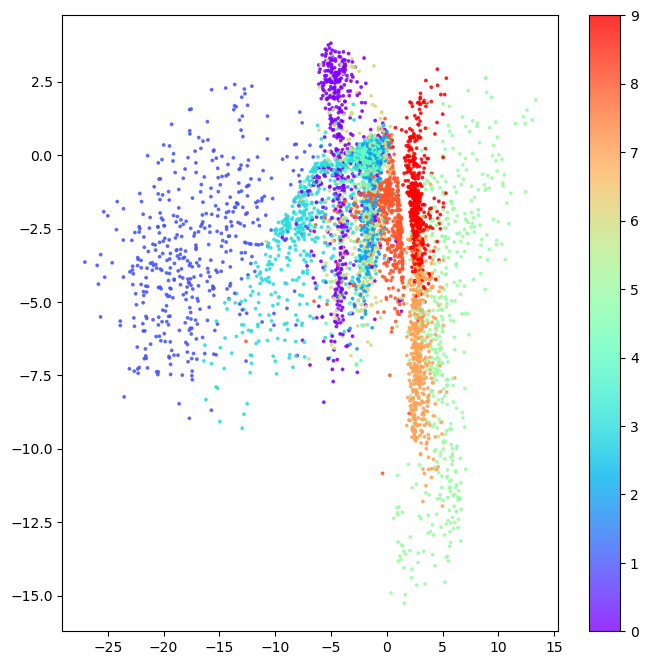

In [14]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], 
            cmap="rainbow", c=Y, alpha=0.8, s=3)
plt.colorbar()
plt.show()

In [15]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(mins, maxs, size=(grid_width*grid_height,args.dim))
sample.shape

(18, 2)

In [16]:
# Decode the sampled points
with torch.no_grad():
    generated_sample = model.decoder(sample).cpu().numpy()
generated_sample.shape

(18, 32, 32, 1)

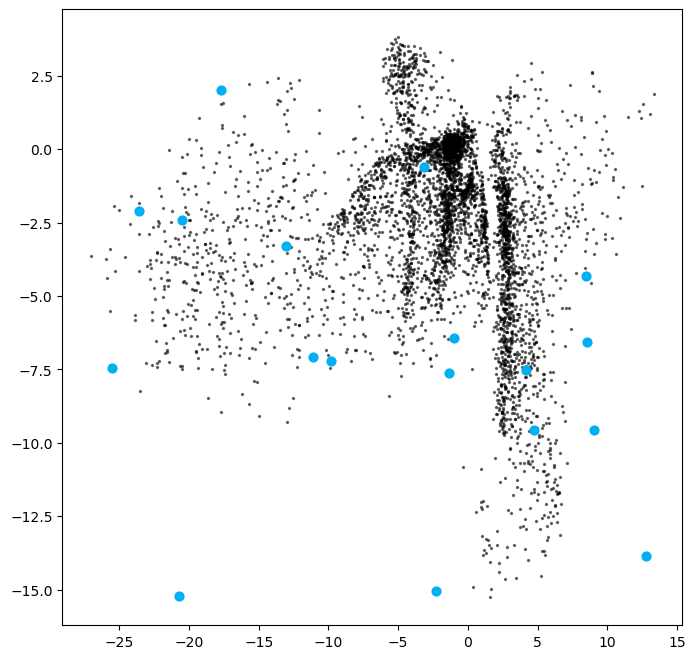

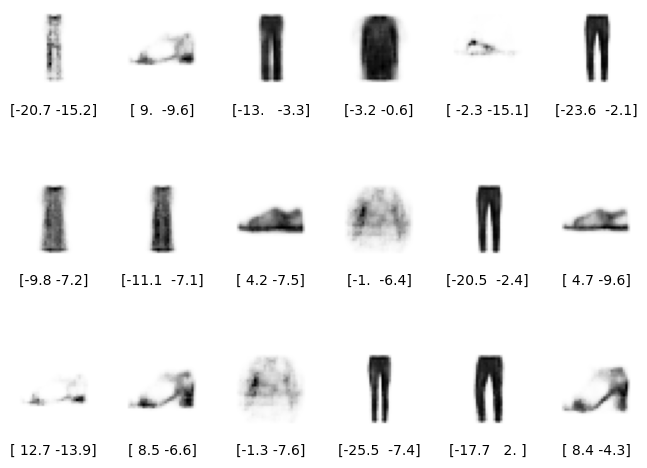

In [17]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(0.5, -0.35, str(np.round(sample[i, :], 1)),
            fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(generated_sample[i, :, :], cmap="Greys")

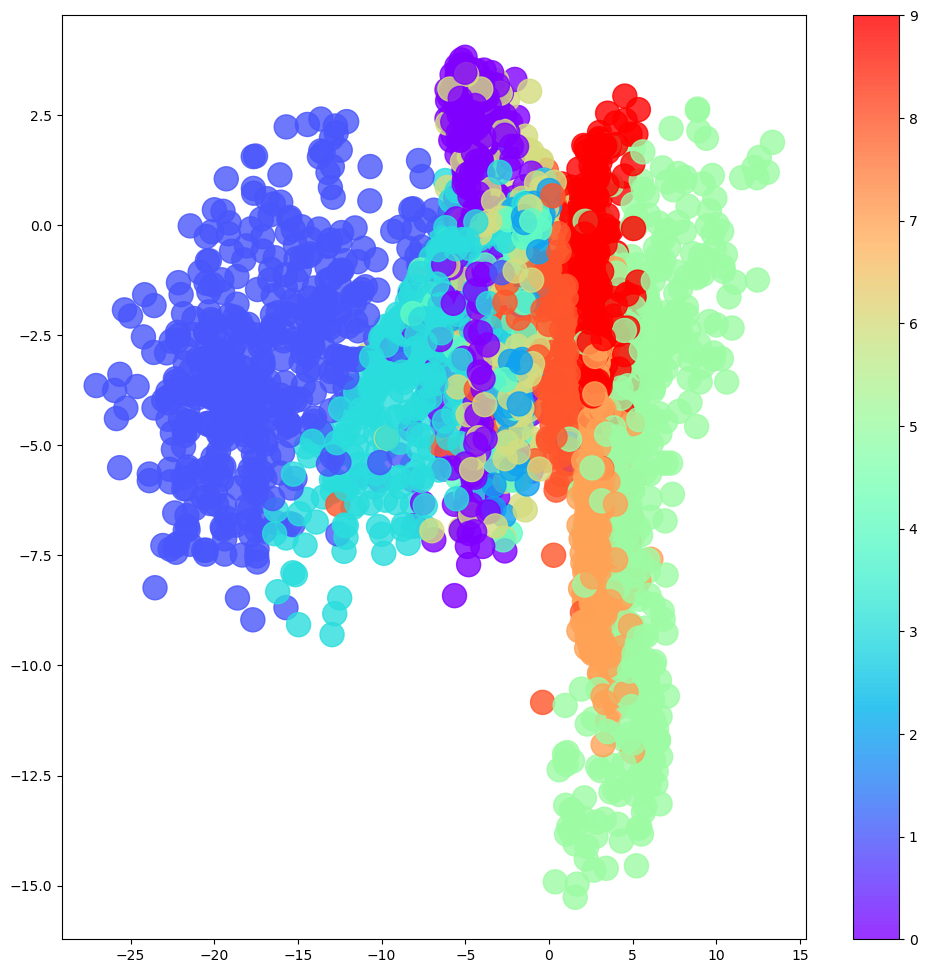

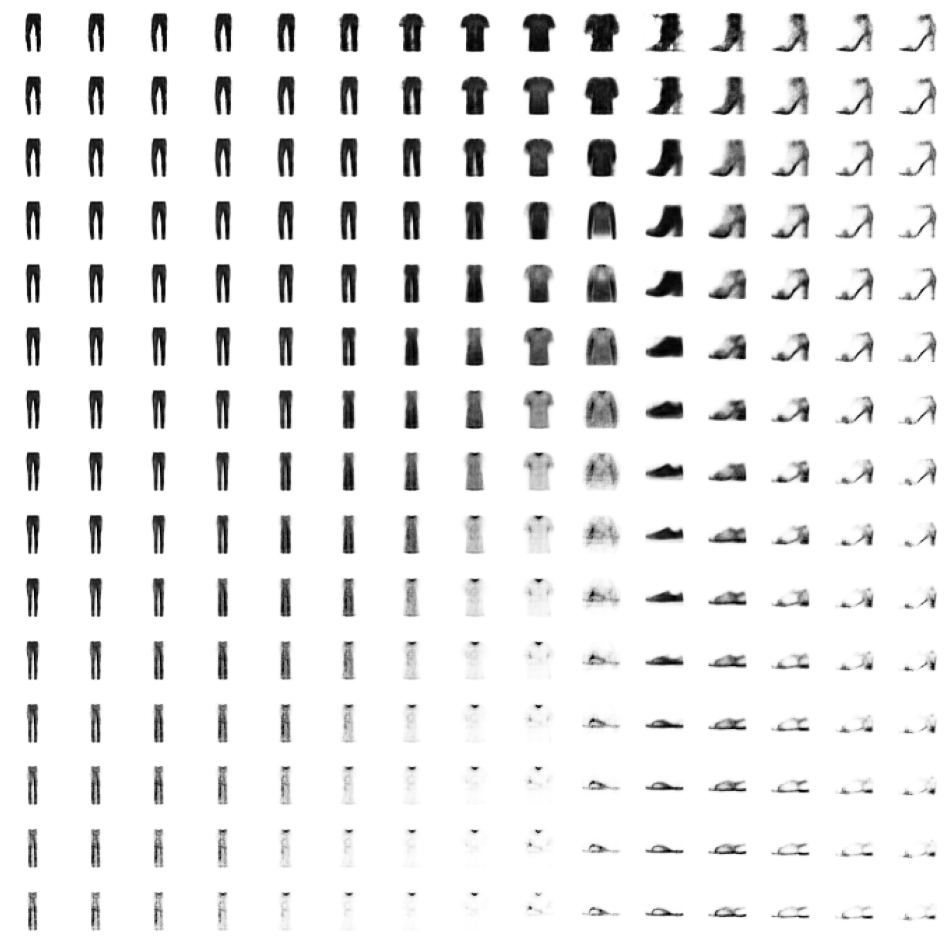

In [18]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap="rainbow",
            c=Y, alpha=0.8, s=300)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

with torch.no_grad():
    generated_sample = model.decoder(grid).cpu().numpy()
# plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(generated_sample[i, :, :], cmap="Greys")